In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import seaborn as sns
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
sartorius_df = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')

In [3]:
# Helper functions
def make_mask(mask_files, image_shape=(520, 704), color=False):
    mask = np.zeros(image_shape).ravel()
    for i, mask_file in enumerate(mask_files):
        couples = np.array(mask_file.split()).reshape(-1, 2).astype(int)
        couples[:, 1] = couples[:, 0] + couples[:, 1]
        for couple in couples:
            if color:
                mask[couple[0]:couple[1]] = i
            else:
                mask[couple[0]:couple[1]] = 1
    mask = mask.reshape(520, 704)
    return mask

def plot_image(image_id='0030fd0e6378'):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    cell_type = sartorius_df.loc[sartorius_df['id'] == image_id, 'cell_type'][0:1].values
    
    file_name = os.path.join(
        '../input/sartorius-cell-instance-segmentation',
        'train', image_id + '.png')
    image = plt.imread(file_name)
    mask_files = sartorius_df.loc[sartorius_df['id'] == image_id, 'annotation']
    mask = make_mask(mask_files)
    
    ax[0].imshow(image, cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(mask, alpha=1, cmap=plt.get_cmap('seismic'))
    ax[1].set_title(f'Source [{image_id}] + Mask {cell_type}')
    ax[1].axis('off')
    plt.show()

### <font color='green'/> **Unique cell type in dataset**

In [4]:
cell_labels = np.sort(sartorius_df['cell_type'].unique())
print('Label in sartorius dataset: ', cell_labels)

Label in sartorius dataset:  ['astro' 'cort' 'shsy5y']


The dataset contains three cell types: `astro`, `cort` and `shsy5y`

In [5]:
HEIGHT = sartorius_df['height'].unique()[0]
WIDTH = sartorius_df['width'].unique()[0]
SHAPE = (HEIGHT, WIDTH)
print('Image shape: ', SHAPE)

assert sartorius_df['height'].nunique() == 1
assert sartorius_df['width'].nunique() == 1

Image shape:  (520, 704)


All the image have the same size, shape of image is: `704 x 520`

In [6]:
print('Number of unique images: ', len(sartorius_df.groupby('id')))
print('Number of unique image and cell type combinations: ', len(sartorius_df.groupby(['id', 'cell_type'])))

Number of unique images:  606
Number of unique image and cell type combinations:  606


Number of unique image and cell type combinations is equal to the number of unique images. This means each image is associated with a unique cell type. So that we can calculate the distribution of image type.

### <font color='green'/> **Data distribution**

In [7]:
ins_dist = sartorius_df['cell_type'].value_counts(normalize=True) * 100
img_dist = sartorius_df.groupby('id').first()['cell_type'].value_counts(normalize=True) * 100

In [8]:
ins_dist=pd.DataFrame({'cell_type': ins_dist.index.to_list(),'percentile': ins_dist.values})
img_dist=pd.DataFrame({'cell_type': img_dist.index.to_list(),'percentile': img_dist.values})
ins_dist['hue'] = 'Ins dist'
img_dist['hue'] = 'Img dis'
res=pd.concat([ins_dist, img_dist])

In [9]:
res

,cell_type,percentile,hue
0,shsy5y,71.055242,Ins dist
1,cort,14.645648,Ins dist
2,astro,14.299110,Ins dist
0,cort,52.805281,Img dis
1,shsy5y,25.577558,Img dis
2,astro,21.617162,Img dis


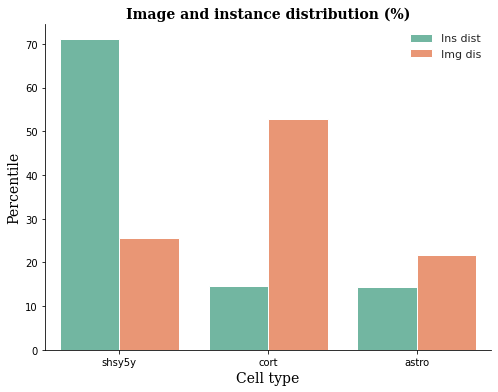

In [10]:
fig = plt.figure(figsize=(8, 6))
axs = plt.subplot(1, 1, 1)

sns.despine()
sns.set_theme(palette='Set2')
sns.set_style('ticks')

sns.barplot(data=res, x='cell_type', y='percentile', hue='hue')
axs.set_xlabel('Cell type', fontdict={'family': 'serif', 'size': 14})
axs.set_ylabel('Percentile', fontdict={'family': 'serif', 'size': 14})
axs.set_title('Image and instance distribution (%)',
              fontdict={'family': 'serif', 'size': 14, 'weight': 'bold'})
leg = axs.get_legend()
leg.set_title('')
leg.set_frame_on(False)

**Observation**
* The `cort` image takes ~ 52% of entire images, the `astro` and `shsy5y` almost have the same distribution
* Each image has many cells, and over 70% cells of the dataset are `shsy5y`, `cort` and `astro` cell have the same distribution

### <font color='green'/> **Number instances per image**

In [11]:
group = sartorius_df.groupby(['id', 'cell_type']).size()

In [12]:
group

id            cell_type
0030fd0e6378  shsy5y       395
0140b3c8f445  astro        108
01ae5a43a2ab  cort          36
026b3c2c4b32  cort          42
029e5b3b89c7  cort          34
                          ... 
fd98d82784a1  astro         11
fe33dfcf4ebd  astro         60
fe3e30f849f4  shsy5y       360
ffc2ead3e8cc  astro        134
ffdb3cc02eef  cort          77
Length: 606, dtype: int64

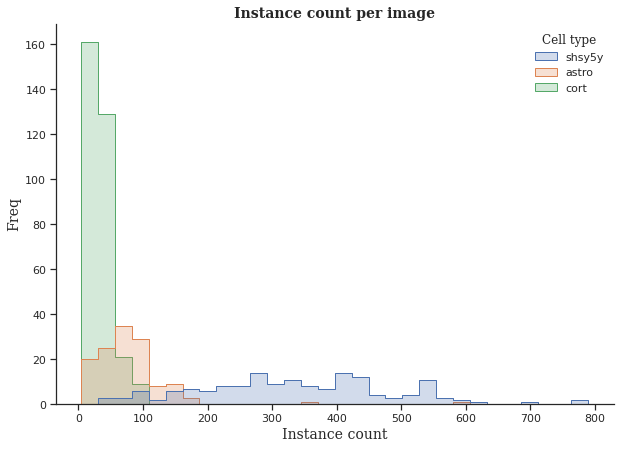

In [13]:
fig = plt.figure(figsize=(10, 7))
axs = plt.subplot(1, 1, 1)

sns.despine()
sns.set_theme()
sns.set_style('ticks')

sns.histplot(x=group.values, data=group, hue='cell_type', element="step")
axs.set_xlabel('Instance count', fontdict={'family': 'serif', 'size': 14})
axs.set_ylabel('Freq', fontdict={'family': 'serif', 'size': 14})
axs.set_title('Instance count per image',
              fontdict={'family': 'serif', 'size': 14, 'weight': 'bold'})
leg = axs.get_legend()
leg.set_title('Cell type', prop={'family': 'serif'})
leg.set_frame_on(False)

plt.show()

In [14]:
# Total cell type
instances_per_img = sartorius_df.groupby('id').size().sort_values()

# Astro type
astro_df = sartorius_df[sartorius_df['cell_type'] == 'astro']
astro_instances_per_img = astro_df.groupby('id').size()

# Cort type
cort_df = sartorius_df[sartorius_df['cell_type'] == 'cort']
cort_instances_per_img = cort_df.groupby('id').size()

# Shsy5y type
shsy5y_df = sartorius_df[sartorius_df['cell_type'] == 'shsy5y']
shsy5y_instances_per_img = shsy5y_df.groupby('id').size()

In [15]:
print('---------- Total cell type statistic ----------')
print(instances_per_img.describe())
print('---------- Astro type statistic ----------')
print(astro_instances_per_img.describe())
print('---------- Cort type statistic ----------')
print(cort_instances_per_img.describe())
print('---------- Shsy5y type statistic ----------')
print(shsy5y_instances_per_img.describe())

---------- Total cell type statistic ----------
count    606.000000
mean     121.427393
std      152.001676
min        4.000000
25%       28.000000
50%       46.000000
75%      140.250000
max      790.000000
dtype: float64
---------- Astro type statistic ----------
count    131.000000
mean      80.320611
std       64.130428
min        5.000000
25%       50.000000
50%       73.000000
75%      100.000000
max      594.000000
dtype: float64
---------- Cort type statistic ----------
count    320.000000
mean      33.678125
std       16.496399
min        4.000000
25%       23.000000
50%       30.000000
75%       39.000000
max      108.000000
dtype: float64
---------- Shsy5y type statistic ----------
count    155.000000
mean     337.329032
std      149.595390
min       49.000000
25%      235.500000
50%      324.000000
75%      429.000000
max      790.000000
dtype: float64


**Observation**
* **Fig 1:** Almost images have less than 200 instances.
* **Fig 2:** We have total 131 `astro` images, just 2 images have more than 200 instances, and the remaining images have less than 200 instances.
* **Fig 3:** We have total 320 `cort` images, just 1 images has around 105-109 instances, and almost images have between 15 and 50 instances.
* **Fig 4:** We have total 155 `shsy5y` images, number of instances per this image type is largest, almost images have more than 200 instances in entire image is `shsy5y`, 80% `shsy5y` images have between 50 and 450 instances.

**Plot images have max and min instances**

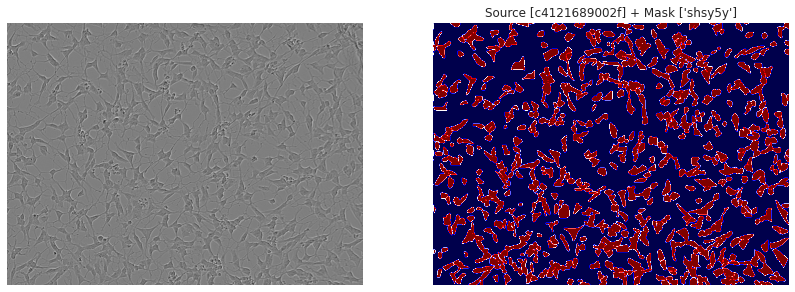

In [16]:
max_num_ins_id = sartorius_df.groupby('id').size().sort_values().index[-1]
plot_image(max_num_ins_id)

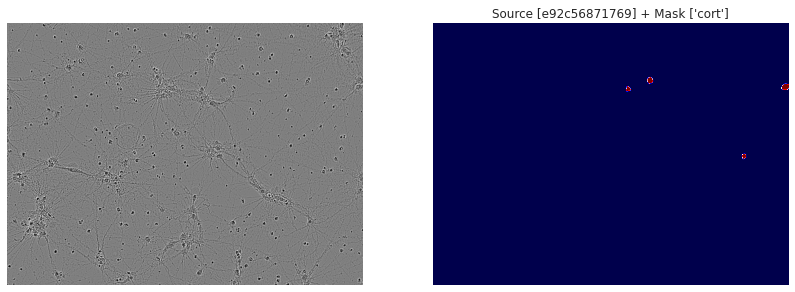

In [17]:
min_num_ins_id = sartorius_df.groupby('id').size().sort_values().index[0]
plot_image(min_num_ins_id)

### <font color='green'/> **Calculating bounding box size**

In [18]:
def rle2mask(rle):
    array = np.fromiter(rle.split(), dtype=np.uint32)
    array = array.reshape(-1, 2)
    array[:, 0] = array[:, 0] - 1
    
    mask_decompressed = np.concatenate([np.arange(i[0], i[0] + i[1], 
                                                 dtype=np.uint32) for i in array])
    
    mask = np.zeros(SHAPE[0] * SHAPE[1], dtype=np.uint32)
    mask[mask_decompressed] = 1
    mask = mask.reshape(SHAPE)
    
    return mask

def get_box_height_width(rle):
    mask = rle2mask(rle)
    nonzero_coords = np.transpose(np.nonzero(mask))
    box_height = nonzero_coords[:, 0].max() - nonzero_coords[:, 0].min()
    box_width = nonzero_coords[:, 1].max() - nonzero_coords[:, 1].min()
    
    return box_height, box_width

sartorius_df[['box_height', 'box_width']] = sartorius_df['annotation'].apply(get_box_height_width).to_list()

In [19]:
print('---------- Total bounding box statistic ----------')
print(sartorius_df[['box_height', 'box_width']].describe())
print('---------- Bounding box of astro type statistic ----------')
print(sartorius_df[sartorius_df['cell_type'] == 'astro'][['box_height', 'box_width']].describe())
print('---------- Bounding box of cort type statistic ----------')
print(sartorius_df[sartorius_df['cell_type'] == 'cort'][['box_height', 'box_width']].describe())
print('---------- Bounding box of shsy5y type statistic ----------')
print(sartorius_df[sartorius_df['cell_type'] == 'shsy5y'][['box_height', 'box_width']].describe())

---------- Total bounding box statistic ----------
         box_height     box_width
count  73585.000000  73585.000000
mean      23.235619     23.374791
std       18.855317     18.625040
min        2.000000      2.000000
25%       13.000000     13.000000
50%       18.000000     18.000000
75%       26.000000     26.000000
max      344.000000    321.000000
---------- Bounding box of astro type statistic ----------
         box_height     box_width
count  10522.000000  10522.000000
mean      51.152347     51.117373
std       33.515645     32.854898
min        2.000000      4.000000
25%       27.000000     28.000000
50%       43.000000     43.000000
75%       66.000000     67.000000
max      344.000000    321.000000
---------- Bounding box of cort type statistic ----------
         box_height     box_width
count  10777.000000  10777.000000
mean      17.269370     17.098914
std        6.063272      6.113021
min        3.000000      3.000000
25%       13.000000     13.000000
50%       16.000

In [20]:
fig = px.scatter(sartorius_df, x='box_width', y='box_height', color='cell_type',
                labels={
                    'box_width': 'Box Width (px)',
                    'box_height': 'Box Height (px)',
                    'cell_type': 'Cell type'
                }, title='Bounding box size for each instance')
fig.show()

**Observation**
* `Cort` type is the smallest cell type in dataset, the average size of box is (17, 17)
* Almost bounding box' shape cover `cort` type is smaller than (70, 70)
* `Shsy5y` is bit bigger than `cort` type, almost bounding box is smaller than (80, 100)
* Average size of `Shsy5y` box is (18, 18)
* `Astro` is the largest cell type in dataset
* Shape of `astro` type is quite unbalanced, this type has smallest and biggest shape over entire instances
* Shape of `astro` goes from 2 pixel to over 300 pixel, but box's size tend to centralize in range [0, 150]

**Plot max width and height instances**

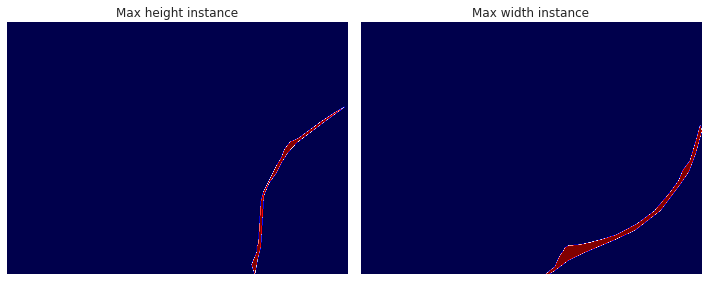

In [21]:
max_width_rle = sartorius_df.loc[sartorius_df['box_width'] == sartorius_df['box_width'].max(), 
                                 'annotation'].values[0]
max_height_rle = sartorius_df.loc[sartorius_df['box_height'] == sartorius_df['box_height'].max(),
                                 'annotation'].values[0]
max_width_mask = rle2mask(max_width_rle)
max_height_mask = rle2mask(max_height_rle)

fig, axs = plt.subplots(nrows=1, ncols= 2, figsize=(10, 4))

axs[0].set_title('Max height instance')
axs[0].imshow(max_height_mask, alpha=1, cmap=plt.get_cmap('seismic'))
axs[0].axis('off')

axs[1].set_title('Max width instance')
axs[1].imshow(max_width_mask, alpha=1, cmap=plt.get_cmap('seismic'))
axs[1].axis('off')


fig.tight_layout()
fig.show()

### <font color='green'/> **References**

https://www.kaggle.com/code/tolgadincer/sartorius-eda-general-overview-and-outliers/notebook